# Marginal Learning in Discrete Markov Networks

In this notebook, we show an example for learning the parameters (potentials) of a Factor Graph or Markov Network given the data and its corresponding marginals.

In the examples, we will generate some data from given models and perform out of clique inference for certain queries.

In [1]:
%load_ext autoreload
%autoreload 2

## Modeling who wins a Football game

In [96]:
from pgmpy.models import FactorGraph, JunctionTree
from pgmpy.factors.discrete import DiscreteFactor
import numpy as np
import networkx as nx
import pandas as pd
import itertools
from pgmpy.estimators import MirrorDescentEstimator
from pgmpy.inference.ExactInference import BeliefPropagation
from pgmpy.factors import FactorDict
from matplotlib import pyplot as plt

### Step 1: Load the `games` data and form a `FactorGraph`

In [2]:
games = pd.read_csv("games.csv")
# Define a "win" to include ties for the home team.
games["homeWin"] = (games.homeFinalScore >= games.visitorFinalScore).map(
    lambda x: "win" if x else "loss"
)
TEAMS = sorted(set(games.homeTeamAbbr).union(set(games.visitorTeamAbbr)))
COLUMNS = ["homeTeamAbbr", "visitorTeamAbbr", "homeWin"]
MAX_SCORE = max(set(games.homeFinalScore).union(games.visitorFinalScore))
df = games[COLUMNS]
df.head()

,homeTeamAbbr,visitorTeamAbbr,homeWin
0,KC,DET,loss
1,MIN,TB,loss
2,NO,TEN,win
3,ATL,CAR,win
4,BAL,HOU,win


In [3]:
G = FactorGraph()
nodes = COLUMNS
state_names = {
    "homeTeamAbbr": TEAMS,
    "visitorTeamAbbr": TEAMS,
}
cardinalities = {"homeTeamAbbr": 32, "visitorTeamAbbr": 32, "homeWin": 2}
factors = [
    DiscreteFactor(
        variables=i,
        cardinality=[cardinalities[j] for j in i],
        values=np.zeros(tuple(cardinalities[j] for j in i)),
        state_names=state_names,
    )
    for i in list(
        itertools.chain.from_iterable(
            [list(itertools.combinations(COLUMNS, i)) for i in range(1, 4)]
        )
    )
]
G.add_nodes_from(nodes=nodes)
G.add_factors(*factors)
G.add_edges_from(
    [(node, factor) for node in nodes for factor in factors if node in factor.scope()]
)
G.check_model()

True

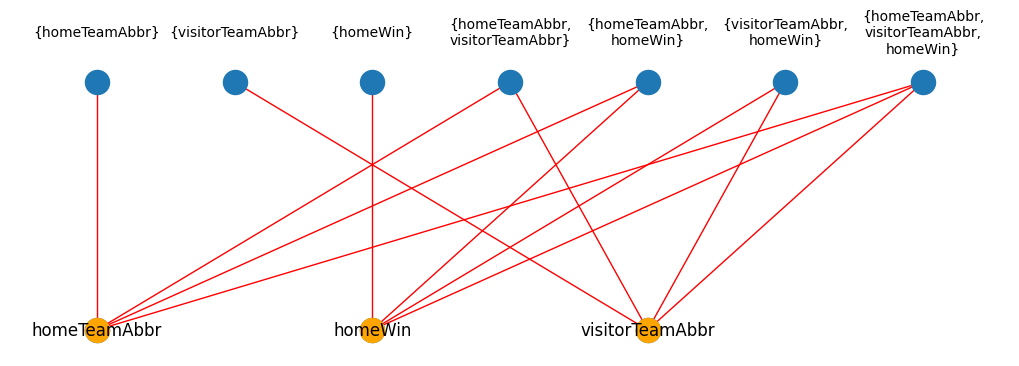

In [4]:
# Print the structure of the Graph to verify its correctness.
plt.figure(figsize=(10, 3))
top = {team: (i * 2, 0) for i, team in enumerate(sorted(nodes))}
bottom = {factor: (i, 1) for i, factor in enumerate(factors)}
# Draw all the variables & factors with their edges.
nx.draw(
    G,
    pos={**top, **bottom},
    edge_color="red",
)
# Draw text labels for the factors above their nodes in the graph.
label_dict = {factor: "{" + ",\n".join(factor.scope()) + "}" for factor in G.factors}
for node, (x, y) in bottom.items():
    plt.text(x, y * 1.2, label_dict[node], fontsize=10, ha="center", va="center")
# Re-draw the variables but with labels this time and colored orange.
nx.draw(
    G.subgraph(nodes),
    node_color="orange",
    pos={**top},
    with_labels=True,
)
plt.show()

### Step 2: Define a model using `MirrorDescentEstimator`

In [5]:
# Initialize model
estimator = MirrorDescentEstimator(model=G, data=games)
marginals = [tuple(i.scope()) for i in G.factors]
observed_factor_dict = FactorDict.from_dataframe(df=games, marginals=marginals)

### Step 3: Learn the marginals 

In [6]:
%%time
_ = estimator.estimate(
    marginals=marginals, metric="L2", iterations=1000, min_belief=1e-12
)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1.22 s, sys: 193 ms, total: 1.41 s
Wall time: 1.39 s


### Step 4: View the true marginals against estimated marginals

In [7]:
tree = estimator.belief_propagation.junction_tree
modeled_factor = tree.factors[0]

In [8]:
# Compare a one-way marginal against a modeled clique.
print("Observed")
print(observed_factor_dict[("homeWin",)])
print("\nModeled")
print(modeled_factor.marginalize(["homeTeamAbbr", "visitorTeamAbbr"], inplace=False))

Observed
+---------------+----------------+
| homeWin       |   phi(homeWin) |
+===============+================+
| homeWin(loss) |       123.0000 |
+---------------+----------------+
| homeWin(win)  |       159.0000 |
+---------------+----------------+

Modeled
+------------+----------------+
| homeWin    |   phi(homeWin) |
+============+================+
| homeWin(0) |       122.9930 |
+------------+----------------+
| homeWin(1) |       158.8818 |
+------------+----------------+


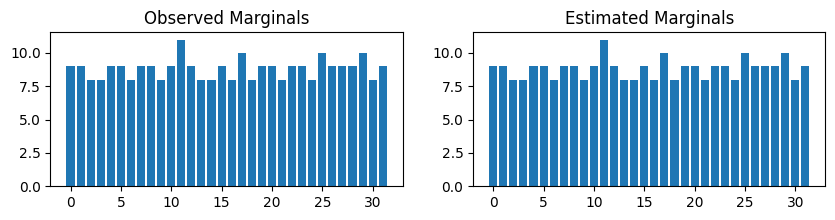

In [9]:
# Compare a larger clique against the true marginals.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2))
visitorTeamAbbr_marginal = observed_factor_dict[("visitorTeamAbbr",)]
total_states = np.prod(visitorTeamAbbr_marginal.cardinality)
axes[0].bar(
    range(total_states),
    visitorTeamAbbr_marginal.values.flatten(),
)
axes[0].set_title("Observed Marginals")
axes[1].bar(
    range(total_states),
    modeled_factor.marginalize(
        ["homeTeamAbbr", "homeWin"], inplace=False
    ).values.flatten(),
)
axes[1].set_title("Estimated Marginals")
plt.show()

In [10]:
# Inference for a hypothetical game.
print("Estimated marginal value")
query_factor = BeliefPropagation(tree).query(
    variables=["homeWin"],
    evidence={"homeTeamAbbr": "PHI", "visitorTeamAbbr": "DAL"},
    joint=True,
    show_progress=True,
)
print(query_factor)

Estimated marginal value
+------------+----------------+
| homeWin    |   phi(homeWin) |
+============+================+
| homeWin(0) |         0.0322 |
+------------+----------------+
| homeWin(1) |         0.9678 |
+------------+----------------+


# Modeling the home & visitor scores

In [118]:
COLUMNS_2 = ["homeTeamAbbr", "visitorTeamAbbr", "homeFinalScore", "visitorFinalScore"]
df2 = games[COLUMNS_2]

df2.head()

,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,KC,DET,20,21
1,MIN,TB,17,20
2,NO,TEN,16,15
3,ATL,CAR,24,10
4,BAL,HOU,25,9


In [119]:
# This time, more marginals are possible.
marginals_2 = list(
    itertools.chain.from_iterable(
        [list(itertools.combinations(COLUMNS_2, i)) for i in range(1, 5)]
    )
)
marginals_2

[('homeTeamAbbr',),
 ('visitorTeamAbbr',),
 ('homeFinalScore',),
 ('visitorFinalScore',),
 ('homeTeamAbbr', 'visitorTeamAbbr'),
 ('homeTeamAbbr', 'homeFinalScore'),
 ('homeTeamAbbr', 'visitorFinalScore'),
 ('visitorTeamAbbr', 'homeFinalScore'),
 ('visitorTeamAbbr', 'visitorFinalScore'),
 ('homeFinalScore', 'visitorFinalScore'),
 ('homeTeamAbbr', 'visitorTeamAbbr', 'homeFinalScore'),
 ('homeTeamAbbr', 'visitorTeamAbbr', 'visitorFinalScore'),
 ('homeTeamAbbr', 'homeFinalScore', 'visitorFinalScore'),
 ('visitorTeamAbbr', 'homeFinalScore', 'visitorFinalScore'),
 ('homeTeamAbbr', 'visitorTeamAbbr', 'homeFinalScore', 'visitorFinalScore')]

In [123]:
# Instead of creating our graph from every possible combination, we can build
# directly from the dataframe, and then setting each factor equal to 0.0.
G_2 = JunctionTree()
nodes = COLUMNS_2
observed_factor_dict = FactorDict.from_dataframe(
    games,
    marginals=marginals_2,
)
factors_2 = observed_factor_dict = [
    i.identity_factor() * 0.0 for i in observed_factor_dict.values()
]
G_2.add_node(node=COLUMNS_2)
G_2.add_factors(observed_factor_dict[-1])
G_2.check_model()

True

In [124]:
print(G_2.nodes)
print(G_2.factors)

[('homeTeamAbbr', 'visitorTeamAbbr', 'homeFinalScore', 'visitorFinalScore')]
[<DiscreteFactor representing phi(homeTeamAbbr:32, visitorTeamAbbr:32, homeFinalScore:45, visitorFinalScore:40) at 0x2f38f47c0>]


In [125]:
# Initialize model
estimator_2 = MirrorDescentEstimator(model=G_2, data=games)

In [126]:
%%time
_ = estimator_2.estimate(
    marginals=marginals_2, metric="L2", iterations=300, min_belief=1e-9
)

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 33.7 s, sys: 37.8 s, total: 1min 11s
Wall time: 1min 12s


In [127]:
tree_2 = estimator_2.belief_propagation.junction_tree
modeled_factor_2 = tree_2.factors[0]

In [ ]:
df3 = modeled_factor_2.sample(n=5_000_000)

In [133]:
df_query = df3.loc[
    (df3.homeTeamAbbr == "SF") & (df3.visitorTeamAbbr == "DET")
].reset_index(drop=True)
df_query.head()

,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,SF,DET,28,13
1,SF,DET,20,21
2,SF,DET,24,21
3,SF,DET,20,21
4,SF,DET,20,21


In [134]:
# Calculate how many times the home team beats the visitor.
(df_query.homeFinalScore >= df_query.visitorFinalScore).mean()

0.24377394636015326

In [136]:
# Count the frequency of score occurences.
counts = (
    df_query.groupby(["homeFinalScore", "visitorFinalScore"])
    .homeTeamAbbr.count()
    .reset_index()
    .rename({"homeTeamAbbr": "count"}, axis=1)
    .sort_values(by="count", ascending=False)
    .reset_index(drop=True)
)
counts["percentage"] = counts["count"] / counts["count"].sum()
counts.head(10)

,homeFinalScore,visitorFinalScore,count,percentage
0,20,21,916,0.438697
1,28,33,388,0.185824
2,28,16,244,0.116858
3,24,21,180,0.086207
4,19,33,139,0.066571
5,28,13,85,0.040709
6,38,41,75,0.035920
7,24,30,39,0.018678
8,20,34,22,0.010536


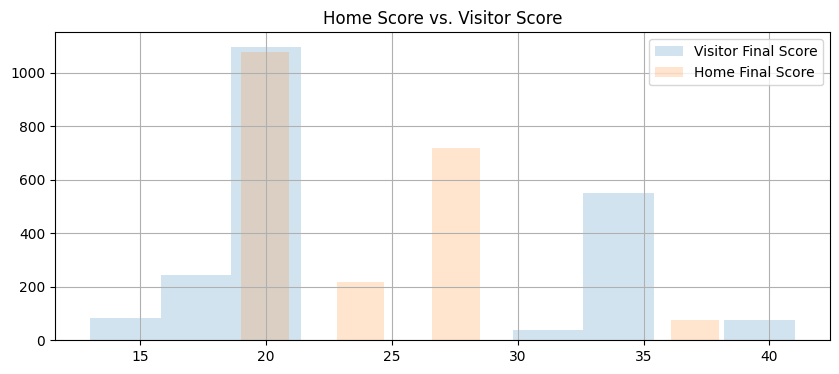

In [137]:
plt.figure(figsize=(10, 4))
df_query.visitorFinalScore.hist(alpha=0.2, label="Visitor Final Score")
df_query.homeFinalScore.hist(alpha=0.2, label="Home Final Score")
plt.title("Home Score vs. Visitor Score")
plt.legend()
plt.show()

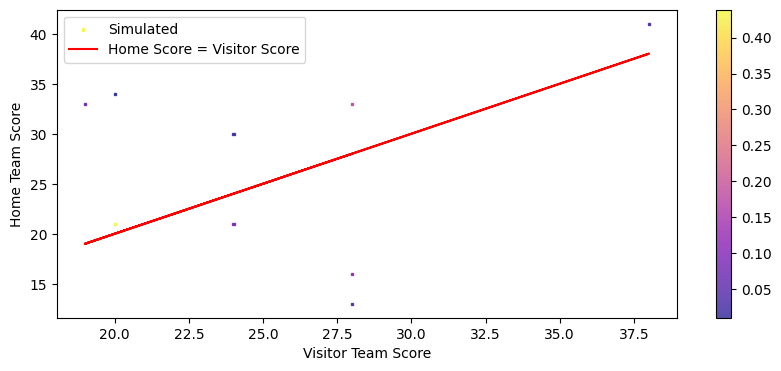

In [138]:
plt.figure(figsize=(10, 4))
plt.scatter(
    x=counts.homeFinalScore,
    y=counts.visitorFinalScore,
    c=counts.percentage,
    s=3,
    cmap="plasma",
    alpha=0.7,
    marker="s",
    label="Simulated",
)
plt.ylabel("Home Team Score")
plt.xlabel("Visitor Team Score")
plt.plot(
    df_query.homeFinalScore,
    df_query.homeFinalScore,
    "r-",
    label="Home Score = Visitor Score",
)
plt.colorbar()
plt.legend()
plt.show()